In [2]:
# Hand Gesture Recognition Model using Deep Learning
# Optimized for Kaggle with GPU acceleration

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

class HandGestureDataLoader:
    """
    Data loader for hand gesture recognition dataset
    """
    def __init__(self, dataset_path, img_size=(128, 128)):
        self.dataset_path = Path(dataset_path)
        self.img_size = img_size
        self.gesture_labels = [
            '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
            '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
        ]
        
    def load_data(self):
        """
        Load and preprocess the dataset
        """
        images = []
        labels = []
        subject_ids = []
        
        print("Loading dataset...")
        
        # Get all subject folders (00-09)
        subject_folders = [folder for folder in self.dataset_path.iterdir() 
                          if folder.is_dir() and folder.name.isdigit()]
        subject_folders.sort()
        
        total_images = 0
        
        for subject_folder in subject_folders:
            subject_id = subject_folder.name
            print(f"Processing subject {subject_id}...")
            
            # Process each gesture folder for this subject
            for gesture_folder in subject_folder.iterdir():
                if gesture_folder.is_dir() and gesture_folder.name in self.gesture_labels:
                    gesture_label = gesture_folder.name
                    
                    # Load all images from this gesture folder
                    image_files = list(gesture_folder.glob('*.png'))
                    
                    for img_path in image_files:
                        try:
                            # Load and preprocess image
                            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                            if img is not None:
                                # Resize image
                                img_resized = cv2.resize(img, self.img_size)
                                # Normalize to [0, 1]
                                img_normalized = img_resized.astype(np.float32) / 255.0
                                
                                images.append(img_normalized)
                                labels.append(gesture_label)
                                subject_ids.append(subject_id)
                                total_images += 1
                                
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
        
        print(f"Total images loaded: {total_images}")
        
        # Convert to numpy arrays
        X = np.array(images)
        y = np.array(labels)
        subjects = np.array(subject_ids)
        
        # Add channel dimension for grayscale images
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        
        return X, y, subjects
    
    def visualize_samples(self, X, y, num_samples=20):
        """
        Visualize sample images from the dataset
        """
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        fig.suptitle('Sample Hand Gestures', fontsize=16)
        
        indices = np.random.choice(len(X), num_samples, replace=False)
        
        for i, idx in enumerate(indices):
            row = i // 5
            col = i % 5
            
            axes[row, col].imshow(X[idx].squeeze(), cmap='gray')
            axes[row, col].set_title(f'{y[idx]}', fontsize=10)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

class HandGestureModel:
    """
    Deep learning model for hand gesture recognition
    """
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None
        
    def build_cnn_model(self):
        """
        Build a CNN model for gesture recognition
        """
        model = keras.Sequential([
            # First Convolutional Block
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Second Convolutional Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Third Convolutional Block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Fourth Convolutional Block
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            
            # Fully Connected Layers
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        self.model = model
        return model
    
    def build_advanced_model(self):
        """
        Build an advanced model with residual connections
        """
        inputs = keras.Input(shape=self.input_shape)
        
        # Initial conv layer
        x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
        
        # Residual blocks
        def residual_block(x, filters, strides=1):
            shortcut = x
            
            x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            
            x = layers.Conv2D(filters, (3, 3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            
            if strides != 1 or shortcut.shape[-1] != filters:
                shortcut = layers.Conv2D(filters, (1, 1), strides=strides)(shortcut)
                shortcut = layers.BatchNormalization()(shortcut)
            
            x = layers.Add()([x, shortcut])
            x = layers.Activation('relu')(x)
            return x
        
        # Apply residual blocks
        x = residual_block(x, 64)
        x = residual_block(x, 64)
        x = residual_block(x, 128, strides=2)
        x = residual_block(x, 128)
        x = residual_block(x, 256, strides=2)
        x = residual_block(x, 256)
        
        # Global average pooling and final layers
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        self.model = keras.Model(inputs, outputs)
        return self.model
    
    def compile_model(self, learning_rate=0.001):
        """
        Compile the model
        """
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """
        Train the model with data augmentation
        """
        # Data augmentation
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        val_datagen = ImageDataGenerator()
        
        train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
        val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                'best_gesture_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        
        # Train the model
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=len(X_val) // batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        return self.history
    
    def plot_training_history(self):
        """
        Plot training history
        """
        if self.history is None:
            print("No training history available")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

class GestureEvaluator:
    """
    Evaluation utilities for gesture recognition model
    """
    def __init__(self, model, label_encoder):
        self.model = model
        self.label_encoder = label_encoder
        
    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation
        """
        # Predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")
        
        # Classification report
        class_names = self.label_encoder.classes_
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))
        
        # Confusion matrix
        self.plot_confusion_matrix(y_true, y_pred, class_names)
        
        return accuracy, y_pred, y_pred_proba
    
    def plot_confusion_matrix(self, y_true, y_pred, class_names):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def predict_single_image(self, image_path):
        """
        Predict gesture for a single image
        """
        # Load and preprocess image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))
        img_normalized = img_resized.astype(np.float32) / 255.0
        img_input = img_normalized.reshape(1, 128, 128, 1)
        
        # Predict
        prediction = self.model.predict(img_input)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        
        gesture_name = self.label_encoder.classes_[predicted_class]
        
        # Display result
        plt.figure(figsize=(8, 6))
        plt.imshow(img_resized, cmap='gray')
        plt.title(f'Predicted: {gesture_name} (Confidence: {confidence:.3f})')
        plt.axis('off')
        plt.show()
        
        return gesture_name, confidence

# Main execution pipeline
def main():
    """
    Main pipeline for hand gesture recognition
    """
    # Configuration
    DATASET_PATH = "/kaggle/input/leapgestrecog/leapGestRecog"   # Update this path
    IMG_SIZE = (128, 128)
    BATCH_SIZE = 32
    EPOCHS = 100
    
    print("Starting Hand Gesture Recognition Pipeline...")
    print("=" * 50)
    
    # Step 1: Load and preprocess data
    print("Step 1: Loading and preprocessing data...")
    data_loader = HandGestureDataLoader(DATASET_PATH, IMG_SIZE)
    X, y, subjects = data_loader.load_data()
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of unique gestures: {len(np.unique(y))}")
    print(f"Gesture classes: {np.unique(y)}")
    
    # Visualize sample data
    data_loader.visualize_samples(X, y)
    
    # Step 2: Encode labels
    print("\nStep 2: Encoding labels...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    num_classes = len(label_encoder.classes_)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Step 3: Split data (subject-independent split)
    print("\nStep 3: Splitting data...")
    # Use subject-independent split for better generalization
    unique_subjects = np.unique(subjects)
    train_subjects = unique_subjects[:8]  # 80% subjects for training
    test_subjects = unique_subjects[8:]   # 20% subjects for testing
    
    train_mask = np.isin(subjects, train_subjects)
    test_mask = np.isin(subjects, test_subjects)
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_categorical[train_mask], y_categorical[test_mask]
    
    # Further split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")  
    print(f"Test set: {X_test.shape}")
    
    # Step 4: Build and train model
    print("\nStep 4: Building and training model...")
    input_shape = X_train.shape[1:]
    
    # Initialize model
    gesture_model = HandGestureModel(input_shape, num_classes)
    
    # Build advanced model with residual connections
    model = gesture_model.build_advanced_model()
    gesture_model.compile_model(learning_rate=0.001)
    
    print(f"Model summary:")
    model.summary()
    
    # Train the model
    print("\nTraining the model...")
    history = gesture_model.train(X_train, y_train, X_val, y_val, 
                                 epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    # Plot training history
    gesture_model.plot_training_history()
    
    # Step 5: Evaluate model
    print("\nStep 5: Evaluating model...")
    evaluator = GestureEvaluator(model, label_encoder)
    accuracy, y_pred, y_pred_proba = evaluator.evaluate_model(X_test, y_test)
    
    # Step 6: Save model and generate comprehensive outputs
    print("\nStep 6: Saving model and generating output files...")
    
    # Save model in multiple formats
    model.save('hand_gesture_recognition_model.h5')  # H5 format
    model.save('hand_gesture_recognition_model.keras')  # Native Keras format
    
    # Save as TensorFlow SavedModel format (compatible with TF Serving)
    tf.saved_model.save(model, 'gesture_model_savedmodel')
    
    # Save label encoder
    import joblib
    joblib.dump(label_encoder, 'label_encoder.pkl')
    
    # Generate comprehensive output files
    generate_output_files(model, label_encoder, history, X_test, y_test, 
                         y_pred, y_pred_proba, accuracy)
    
    print("All output files generated successfully!")
    print(f"Final test accuracy: {accuracy:.4f}")
    
    return model, label_encoder, history

def generate_output_files(model, label_encoder, history, X_test, y_test, 
                         y_pred, y_pred_proba, accuracy):
    """
    Generate comprehensive output files
    """
    import json
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Model Configuration and Results Summary
    results_summary = {
        'timestamp': timestamp,
        'model_architecture': 'Advanced CNN with Residual Connections',
        'input_shape': list(model.input_shape[1:]),
        'num_classes': len(label_encoder.classes_),
        'class_names': label_encoder.classes_.tolist(),
        'test_accuracy': float(accuracy),
        'total_parameters': model.count_params(),
        'training_epochs': len(history.history['accuracy']),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1])
    }
    
    with open(f'model_results_summary_{timestamp}.json', 'w') as f:
        json.dump(results_summary, f, indent=4)
    
    # 2. Detailed Classification Report
    y_true = np.argmax(y_test, axis=1)
    class_report = classification_report(y_true, y_pred, 
                                       target_names=label_encoder.classes_,
                                       output_dict=True)
    
    with open(f'classification_report_{timestamp}.json', 'w') as f:
        json.dump(class_report, f, indent=4)
    
    # 3. Training History CSV
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'training_history_{timestamp}.csv', index=False)
    
    # 4. Predictions CSV
    predictions_df = pd.DataFrame({
        'true_label_index': y_true,
        'predicted_label_index': y_pred,
        'true_label_name': [label_encoder.classes_[i] for i in y_true],
        'predicted_label_name': [label_encoder.classes_[i] for i in y_pred],
        'confidence': np.max(y_pred_proba, axis=1),
        'correct_prediction': y_true == y_pred
    })
    
    # Add probability scores for each class
    for i, class_name in enumerate(label_encoder.classes_):
        predictions_df[f'prob_{class_name}'] = y_pred_proba[:, i]
    
    predictions_df.to_csv(f'test_predictions_{timestamp}.csv', index=False)
    
    # 5. Confusion Matrix Data
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, 
                        index=label_encoder.classes_,
                        columns=label_encoder.classes_)
    cm_df.to_csv(f'confusion_matrix_{timestamp}.csv')
    
    # 6. Per-Class Performance Metrics
    per_class_metrics = []
    for i, class_name in enumerate(label_encoder.classes_):
        class_mask = (y_true == i)
        class_predictions = y_pred[class_mask]
        class_probabilities = y_pred_proba[class_mask, i]
        
        per_class_metrics.append({
            'class_name': class_name,
            'class_index': i,
            'total_samples': int(np.sum(class_mask)),
            'correct_predictions': int(np.sum(class_predictions == i)),
            'accuracy': float(np.mean(class_predictions == i)) if np.sum(class_mask) > 0 else 0,
            'avg_confidence': float(np.mean(class_probabilities)) if np.sum(class_mask) > 0 else 0,
            'min_confidence': float(np.min(class_probabilities)) if np.sum(class_mask) > 0 else 0,
            'max_confidence': float(np.max(class_probabilities)) if np.sum(class_mask) > 0 else 0
        })
    
    per_class_df = pd.DataFrame(per_class_metrics)
    per_class_df.to_csv(f'per_class_performance_{timestamp}.csv', index=False)
    
    # 7. Model Architecture Summary
    with open(f'model_architecture_{timestamp}.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    # 8. Save Training Plots
    save_training_plots(history, timestamp)
    save_confusion_matrix_plot(y_true, y_pred, label_encoder.classes_, timestamp)
    
    # 9. Generate README file
    generate_readme_file(timestamp, results_summary)
    
    print(f"\nGenerated Output Files:")
    print(f"📊 model_results_summary_{timestamp}.json - Overall model performance summary")
    print(f"📋 classification_report_{timestamp}.json - Detailed per-class metrics")
    print(f"📈 training_history_{timestamp}.csv - Training/validation curves data")
    print(f"🎯 test_predictions_{timestamp}.csv - Individual test predictions with probabilities")
    print(f"🔄 confusion_matrix_{timestamp}.csv - Confusion matrix data")
    print(f"📊 per_class_performance_{timestamp}.csv - Per-class detailed performance")
    print(f"🏗️ model_architecture_{timestamp}.txt - Model architecture details")
    print(f"📊 training_plots_{timestamp}.png - Training history visualization")
    print(f"🔥 confusion_matrix_{timestamp}.png - Confusion matrix heatmap")
    print(f"📖 README_{timestamp}.md - Complete documentation")
    print(f"🤖 hand_gesture_recognition_model.h5 - Keras model file (H5 format)")
    print(f"🤖 hand_gesture_recognition_model.keras - Keras model file (native format)") 
    print(f"🤖 gesture_model_savedmodel/ - TensorFlow SavedModel format")
    print(f"🏷️ label_encoder.pkl - Label encoder for predictions")

def save_training_plots(history, timestamp):
    """
    Save training history plots
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot learning rate if available
    if 'lr' in history.history:
        ax3.plot(history.history['lr'], linewidth=2, color='orange')
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    
    # Plot accuracy difference (overfitting indicator)
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    acc_diff = train_acc - val_acc
    
    ax4.plot(acc_diff, linewidth=2, color='red')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Overfitting Indicator\n(Training - Validation Accuracy)', 
                 fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'training_plots_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_confusion_matrix_plot(y_true, y_pred, class_names, timestamp):
    """
    Save confusion matrix plot
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names,
               cbar_kws={'label': 'Number of Samples'})
    plt.title('Confusion Matrix - Hand Gesture Recognition', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add accuracy text
    accuracy = np.trace(cm) / np.sum(cm)
    plt.text(len(class_names)/2, -0.5, f'Overall Accuracy: {accuracy:.3f}', 
             ha='center', va='top', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_readme_file(timestamp, results_summary):
    """
    Generate comprehensive README file
    """
    readme_content = f"""# Hand Gesture Recognition Model Results

## Model Information
- **Generated**: {timestamp}
- **Architecture**: {results_summary['model_architecture']}
- **Input Shape**: {results_summary['input_shape']}
- **Number of Classes**: {results_summary['num_classes']}
- **Total Parameters**: {results_summary['total_parameters']:,}

## Performance Summary
- **Test Accuracy**: {results_summary['test_accuracy']:.4f}
- **Best Validation Accuracy**: {results_summary['best_val_accuracy']:.4f}
- **Training Epochs**: {results_summary['training_epochs']}

## Gesture Classes
{chr(10).join([f"- {i}: {class_name}" for i, class_name in enumerate(results_summary['class_names'])])}

## Output Files Description

### Model Files
- `hand_gesture_recognition_model.h5` - Keras model in HDF5 format
- `hand_gesture_recognition_model.keras` - Keras model in native format  
- `gesture_model_savedmodel/` - TensorFlow SavedModel format (recommended for deployment)
- `label_encoder.pkl` - Label encoder for converting between class names and indices

### Performance Analysis
- `model_results_summary_{timestamp}.json` - Overall model performance metrics
- `classification_report_{timestamp}.json` - Detailed per-class precision, recall, F1-score
- `per_class_performance_{timestamp}.csv` - Detailed per-class analysis with confidence scores
- `confusion_matrix_{timestamp}.csv` - Confusion matrix in CSV format

### Training Data
- `training_history_{timestamp}.csv` - Training and validation metrics for each epoch
- `training_plots_{timestamp}.png` - Visualization of training progress

### Predictions
- `test_predictions_{timestamp}.csv` - Individual test predictions with:
  - True and predicted labels
  - Confidence scores
  - Probability distributions for all classes
  - Correctness indicators

### Visualizations
- `confusion_matrix_{timestamp}.png` - Confusion matrix heatmap
- `training_plots_{timestamp}.png` - Training history plots

## Usage Instructions

### Loading the Model
```python
import tensorflow as tf
import joblib

# Load model (choose one format)
model = tf.keras.models.load_model('hand_gesture_recognition_model.h5')  # H5 format
# OR
model = tf.keras.models.load_model('hand_gesture_recognition_model.keras')  # Native Keras format
# OR load SavedModel format
model = tf.saved_model.load('gesture_model_savedmodel')

# Load label encoder
label_encoder = joblib.load('label_encoder.pkl')
```

### Making Predictions
```python
import cv2
import numpy as np

# Load and preprocess image
img = cv2.imread('your_image.png', cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))
img_normalized = img_resized.astype(np.float32) / 255.0
img_input = img_normalized.reshape(1, 128, 128, 1)

# Predict
prediction = model.predict(img_input)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)
gesture_name = label_encoder.classes_[predicted_class]

print(f"Predicted gesture: {{gesture_name}} (confidence: {{confidence:.3f}})")
```

## Model Architecture
See `model_architecture_{timestamp}.txt` for detailed layer information.

## Notes
- Model was trained with subject-independent split for better generalization
- Data augmentation was applied during training
- Early stopping and learning rate reduction were used for optimal performance
"""

    with open(f'README_{timestamp}.md', 'w') as f:
        f.write(readme_content)

# Add import for datetime at the top of the file

# Utility functions for real-time prediction
def load_trained_model():
    """
    Load pre-trained model and label encoder
    """
    model = keras.models.load_model('hand_gesture_recognition_model.h5')
    label_encoder = joblib.load('label_encoder.pkl')
    return model, label_encoder

def preprocess_frame(frame, img_size=(128, 128)):
    """
    Preprocess frame for real-time prediction
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Resize and normalize
    frame_resized = cv2.resize(frame, img_size)
    frame_normalized = frame_resized.astype(np.float32) / 255.0
    frame_input = frame_normalized.reshape(1, img_size[0], img_size[1], 1)
    
    return frame_input

def predict_gesture(model, label_encoder, frame):
    """
    Predict gesture from frame
    """
    processed_frame = preprocess_frame(frame)
    prediction = model.predict(processed_frame)
    
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    gesture_name = label_encoder.classes_[predicted_class]
    
    return gesture_name, confidence

# Run the main pipeline
if __name__ == "__main__":
    # Update the dataset path before running
    print("Please update DATASET_PATH in the main() function before running!")


2025-06-28 12:58:27.063517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751115507.295883      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751115507.371788      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0
Please update DATASET_PATH in the main() function before running!


Starting Hand Gesture Recognition Pipeline...
Step 1: Loading and preprocessing data...
Loading dataset...
Processing subject 00...
Processing subject 01...
Processing subject 02...
Processing subject 03...
Processing subject 04...
Processing subject 05...
Processing subject 06...
Processing subject 07...
Processing subject 08...
Processing subject 09...
Total images loaded: 20000
Dataset shape: (20000, 128, 128, 1)
Number of unique gestures: 10
Gesture classes: ['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


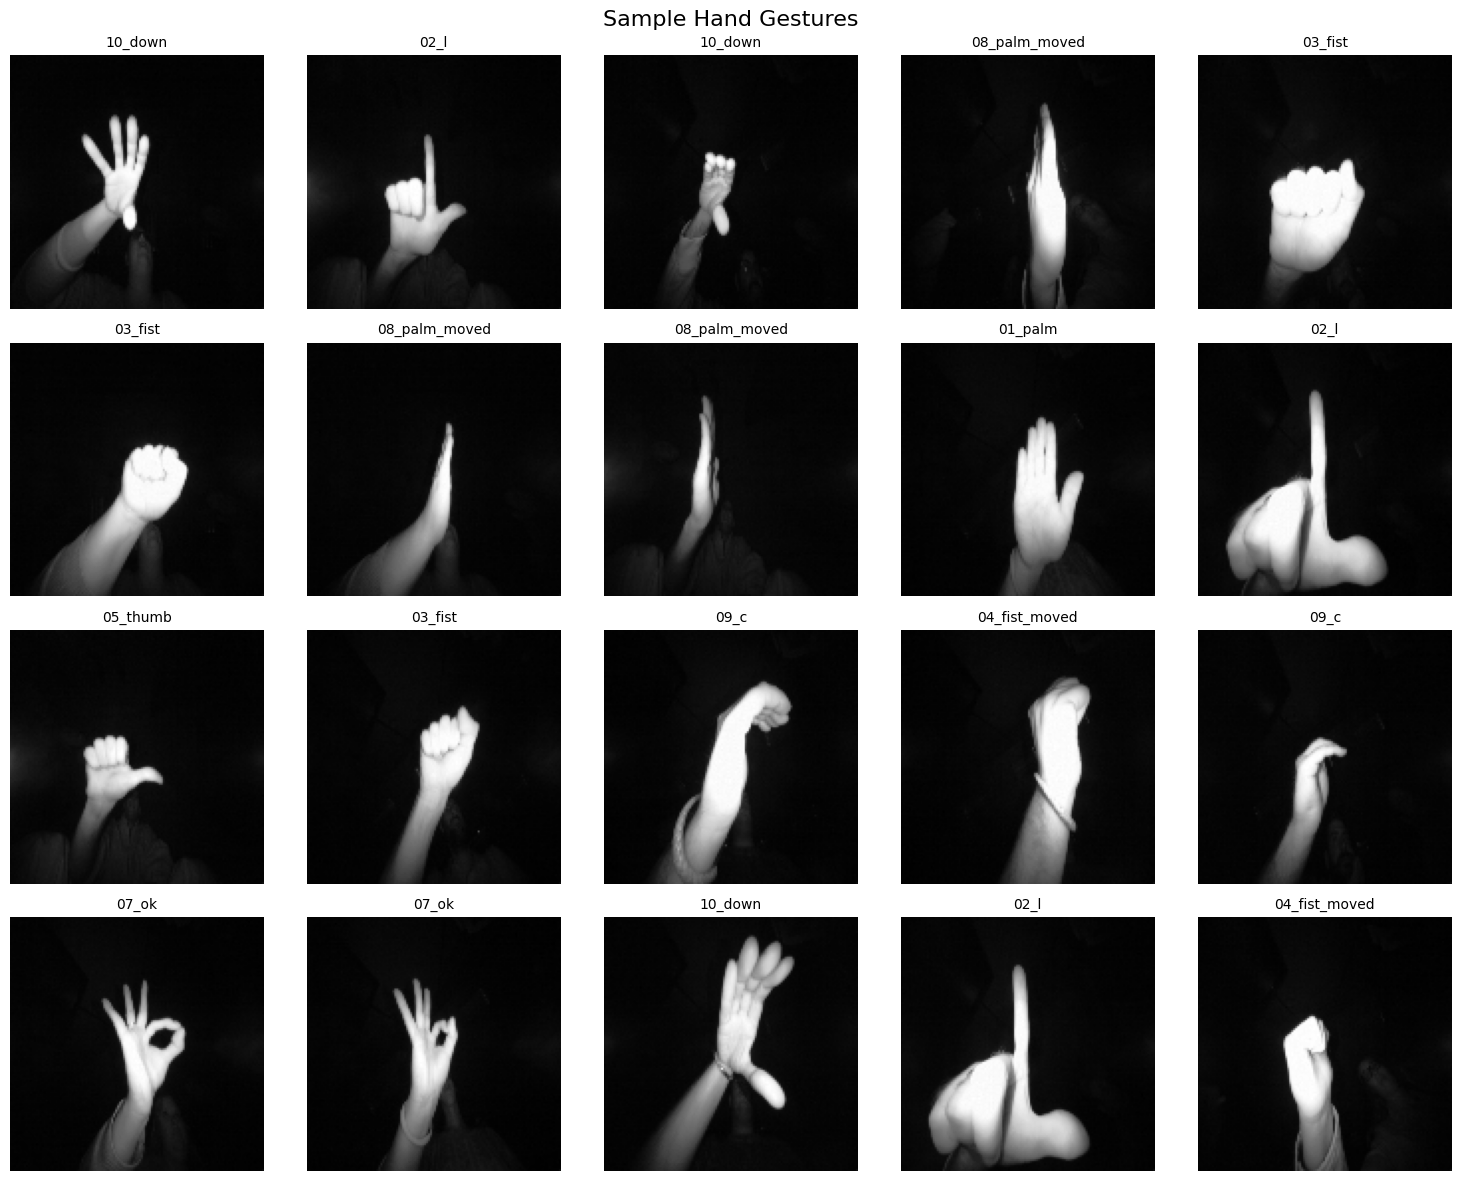


Step 2: Encoding labels...
Number of classes: 10
Classes: ['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']

Step 3: Splitting data...
Training set: (12800, 128, 128, 1)
Validation set: (3200, 128, 128, 1)
Test set: (4000, 128, 128, 1)

Step 4: Building and training model...


I0000 00:00:1751115745.317485      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          3,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,919,946 (11.14 MB)

 Trainable params: 2,915,466 (11.12 MB)

 Non-trainable params: 4,480 (17.50 KB)


Training the model...
Epoch 1/100


I0000 00:00:1751115761.887102     100 service.cc:148] XLA service 0x7a7844001fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751115761.888045     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751115763.260676     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0919 - loss: 2.6277 

I0000 00:00:1751115770.393502     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5576 - loss: 1.2216
Epoch 1: val_accuracy improved from -inf to 0.19563, saving model to best_gesture_model.h5
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - accuracy: 0.5581 - loss: 1.2202 - val_accuracy: 0.1956 - val_loss: 7.5974 - learning_rate: 0.0010
Epoch 2/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9436 - loss: 0.1688
Epoch 2: val_accuracy improved from 0.19563 to 0.69531, saving model to best_gesture_model.h5
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1687 - val_accuracy: 0.6953 - val_loss: 2.1578 - learning_rate: 0.0010
Epoch 3/100
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9659 - loss: 0.1078
Epoch 3: val_accuracy improved from 0.69531 to 0.90125, saving model to best_gesture_model.h5
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9660 - loss: 0.1077 - val_accuracy: 0.9013 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 4/100
399/400 ━━━━━━━━━━━━━━━━━━━━

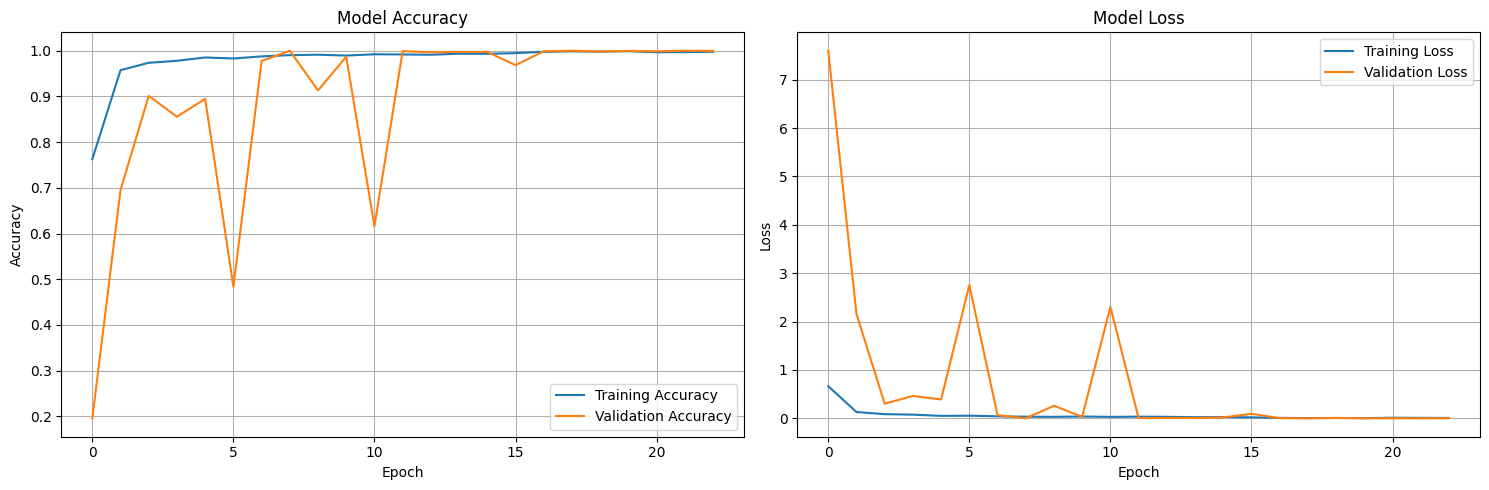


Step 5: Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test Accuracy: 0.8590

Classification Report:
               precision    recall  f1-score   support

      01_palm       0.70      0.83      0.76       400
         02_l       1.00      0.92      0.96       400
      03_fist       1.00      0.26      0.41       400
04_fist_moved       0.62      0.81      0.70       400
     05_thumb       0.92      0.77      0.84       400
     06_index       1.00      1.00      1.00       400
        07_ok       0.99      1.00      1.00       400
08_palm_moved       0.86      1.00      0.92       400
         09_c       1.00      1.00      1.00       400
      10_down       0.77      1.00      0.87       400

     accuracy                           0.86      4000
    macro avg       0.88      0.86      0.85      4000
 weighted avg       0.88      0.86      0.85      4000



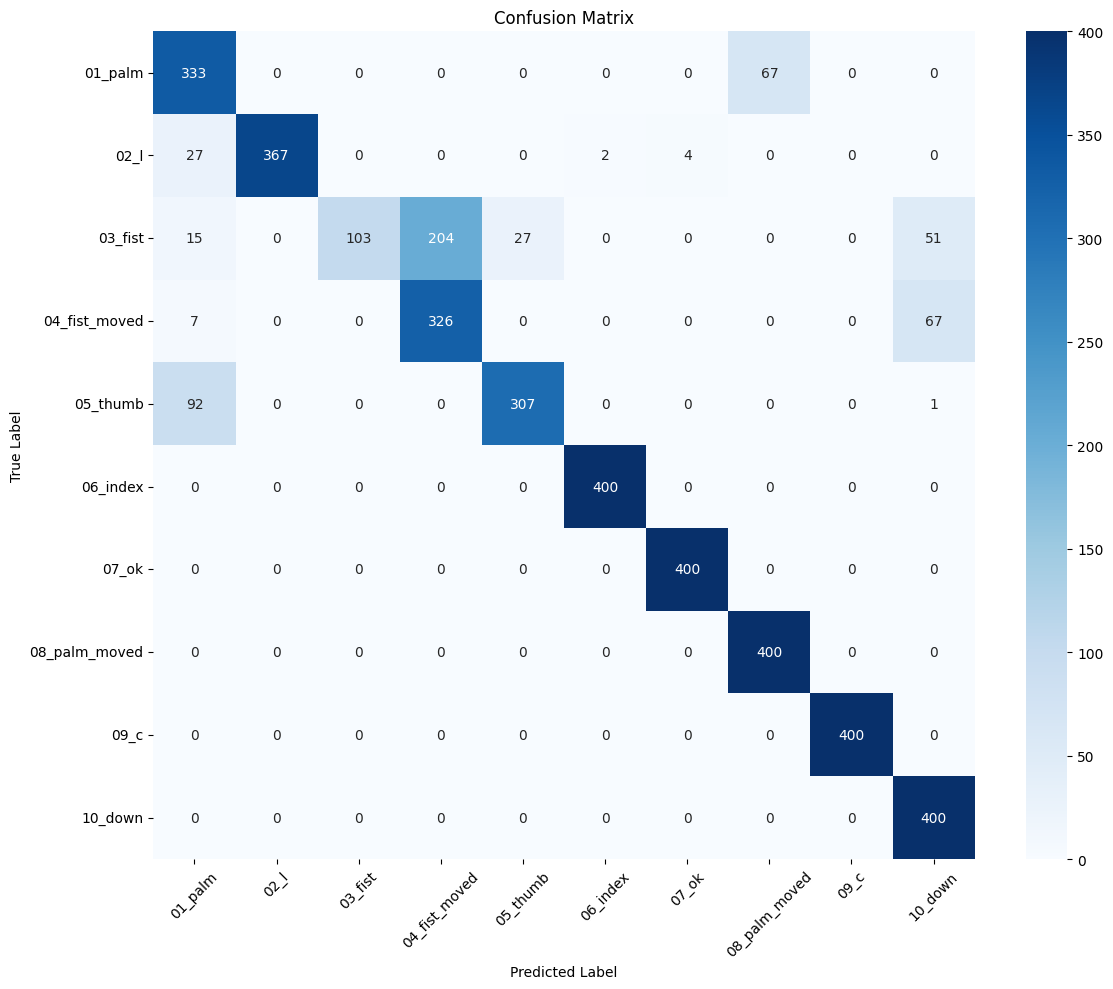


Step 6: Saving model and generating output files...


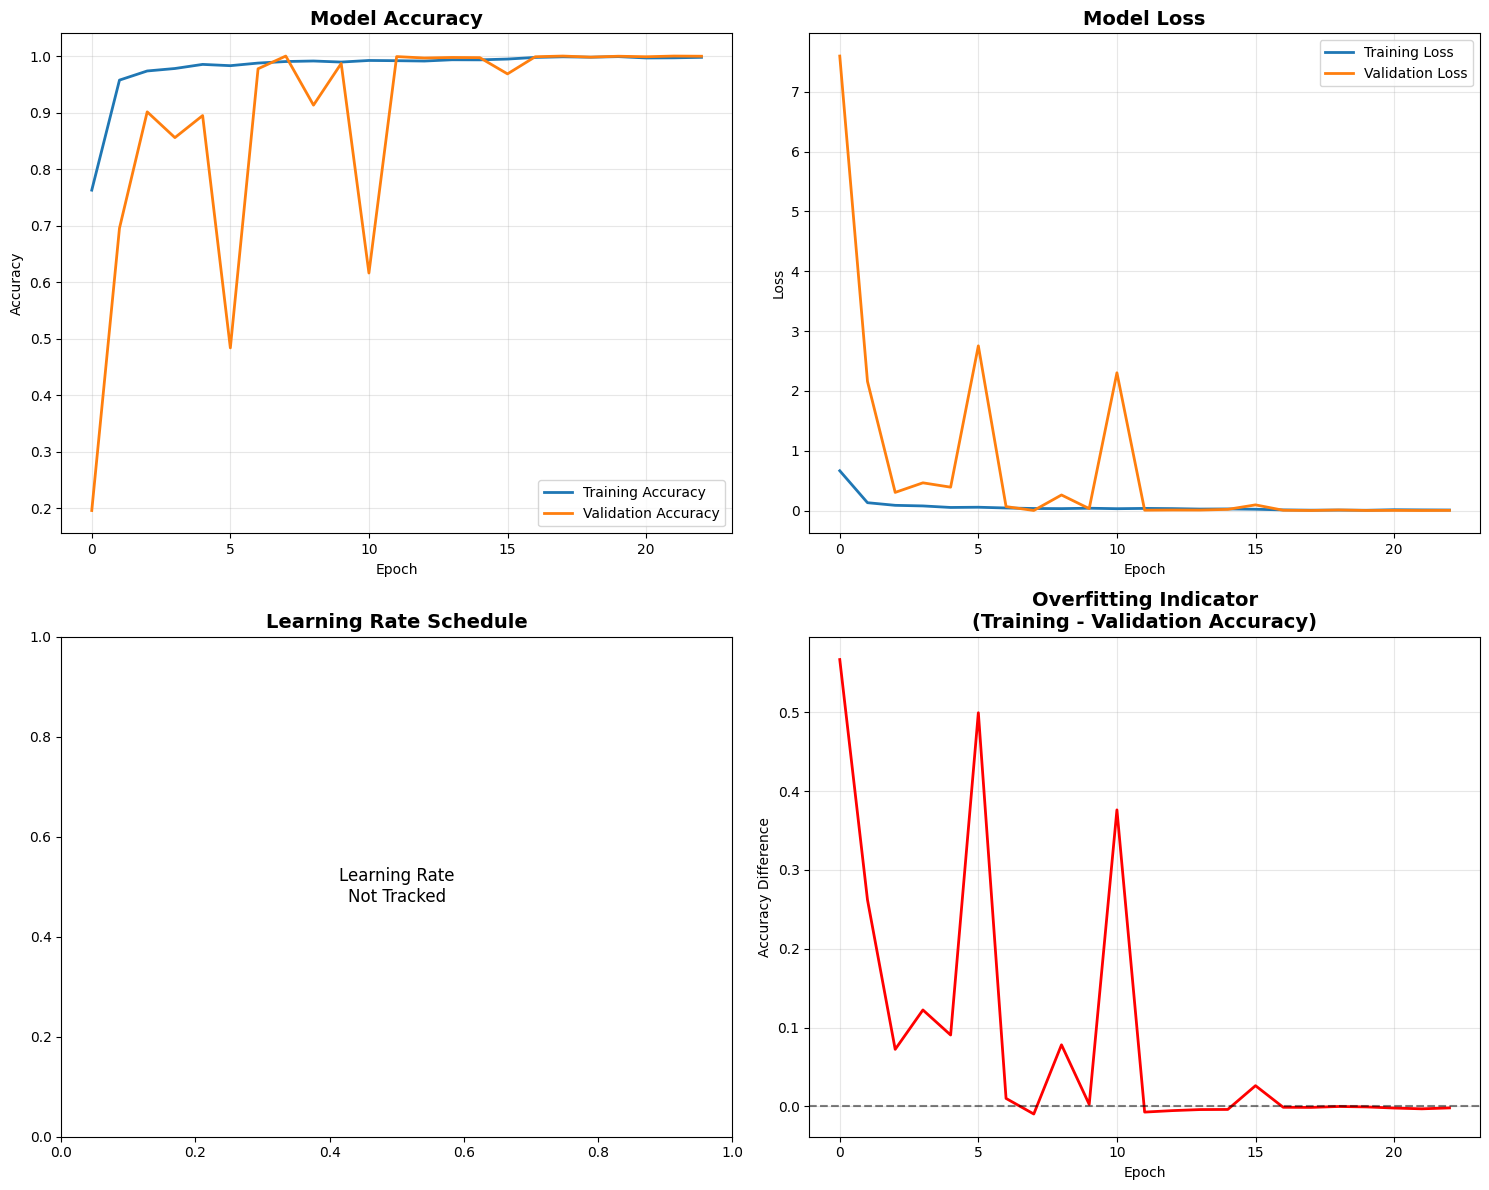

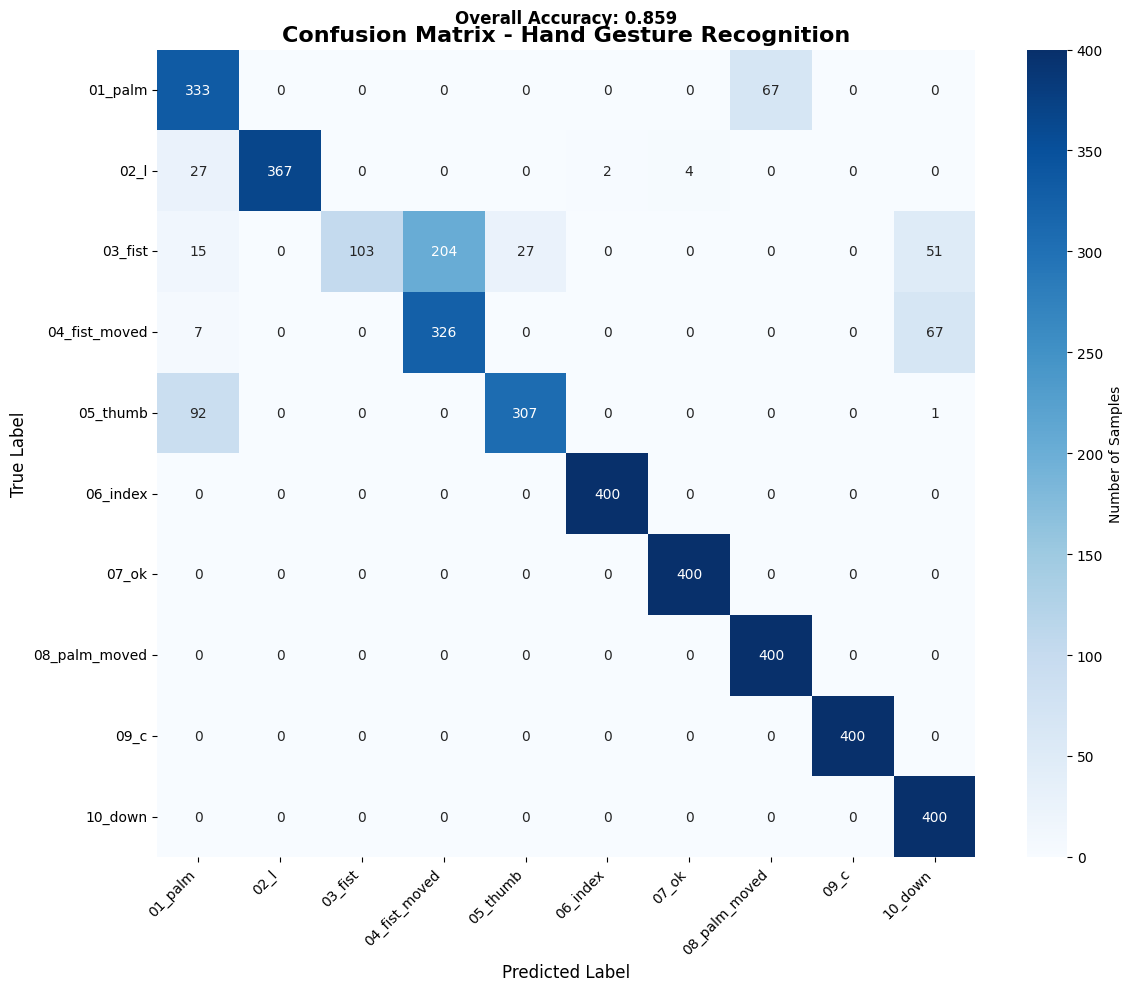


Generated Output Files:
📊 model_results_summary_20250628_130944.json - Overall model performance summary
📋 classification_report_20250628_130944.json - Detailed per-class metrics
📈 training_history_20250628_130944.csv - Training/validation curves data
🎯 test_predictions_20250628_130944.csv - Individual test predictions with probabilities
🔄 confusion_matrix_20250628_130944.csv - Confusion matrix data
📊 per_class_performance_20250628_130944.csv - Per-class detailed performance
🏗️ model_architecture_20250628_130944.txt - Model architecture details
📊 training_plots_20250628_130944.png - Training history visualization
🔥 confusion_matrix_20250628_130944.png - Confusion matrix heatmap
📖 README_20250628_130944.md - Complete documentation
🤖 hand_gesture_recognition_model.h5 - Keras model file (H5 format)
🤖 hand_gesture_recognition_model.keras - Keras model file (native format)
🤖 gesture_model_savedmodel/ - TensorFlow SavedModel format
🏷️ label_encoder.pkl - Label encoder for predictions
All ou

In [3]:
model, label_encoder, history = main()